## Naimportovaný marek.coderslab@gmail.com.ics z Google Calendar

In [2]:
import pandas as pd
from icalendar import Calendar

# Načti ICS soubor
with open("marek.coderslab@gmail.com.ics", "rb") as f:
    gcal = Calendar.from_ical(f.read())

events = []
for component in gcal.walk():
    if component.name == "VEVENT":
        events.append({
            "summary": str(component.get("summary")),
            "start": component.get("dtstart").dt,
            "end": component.get("dtend").dt,
            "description": str(component.get("description")),
        })

df = pd.DataFrame(events)
print(df.head())


       summary                     start                       end description
0  TOPFit: ZRT 2025-07-07 13:00:00+00:00 2025-07-07 14:00:00+00:00        None
1  TOPFit: ZRT 2025-06-30 12:45:00+00:00 2025-06-30 13:45:00+00:00        None
2   TOPFit: PB 2025-06-26 12:00:00+00:00 2025-06-26 13:00:00+00:00        None
3  TOPFIT: ZRT 2025-08-11 12:30:00+00:00 2025-08-11 13:30:00+00:00        None
4   TOPFit: PB 2025-07-03 13:30:00+00:00 2025-07-03 15:15:00+00:00         544


In [2]:
# !pip install icalendar


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


# Kód při stažení .zip s .ics z Export calendar "Marek.Coderslab"

In [14]:
import pandas as pd
from icalendar import Calendar
import zipfile
import re

zip_path = "marek.coderslab@gmail.com.ical.zip"

# otevřeme ZIP a najdeme ICS soubor
with zipfile.ZipFile(zip_path, "r") as z:
    # najdi soubor končící na .ics (pokud jich je víc, vezme první)
    ics_name = [f for f in z.namelist() if f.endswith(".ics")][0]
    with z.open(ics_name) as f:
        gcal = Calendar.from_ical(f.read())

events = []
for component in gcal.walk():
    if component.name == "VEVENT":
        summary = str(component.get("summary") or "")

        # odstraň prefix "TOPFIT:" bez ohledu na velikost
        clean_summary = re.sub(r"^\s*TOPFIT:\s*", "", summary, flags=re.IGNORECASE).strip()

        start = component.get("dtstart").dt
        end = component.get("dtend").dt

        events.append({
            "summary": clean_summary,
            "start": start,
            "end": end
        })

df_topfit = pd.DataFrame(events)

# jen datum
df_topfit["date"] = pd.to_datetime(df_topfit["start"]).dt.date

# délka v minutách
df_topfit["doba"] = (df_topfit["end"] - df_topfit["start"]).dt.total_seconds() / 60

# vyber sloupce a seřaď od nejnovějšího
df_topfit = df_topfit[["date", "summary", "doba"]].sort_values("date", ascending=False).reset_index(drop=True)

print(df_topfit.head(20))


          date            summary  doba
0   2025-08-28                ZRT  60.0
1   2025-08-21                 PB  60.0
2   2025-08-18                ZRT  60.0
3   2025-08-14                 PB  60.0
4   2025-08-11                ZRT  60.0
5   2025-08-07       Nohy, břicho  60.0
6   2025-08-04  PB - roztrž. ruky  60.0
7   2025-07-31                ZRT  60.0
8   2025-07-24                 PB  60.0
9   2025-07-22                ZRT  60.0
10  2025-07-17                 PB  60.0
11  2025-07-14                ZRT  60.0
12  2025-07-10                 PB  60.0
13  2025-07-07                ZRT  60.0
14  2025-07-03                 PB  60.0
15  2025-06-30                ZRT  60.0
16  2025-06-26                 PB  60.0


In [15]:
# !pip install google-api-python-client google-auth-httplib2 google-auth-oauthlib pandas


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 3.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


# Kód využívající přímé připojení na Google calendar API

In [2]:
import os
import pandas as pd
import re
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from datetime import datetime

# aplikace může pouze číst události z kalendáře (žádné přidávání, mazání ani úpravy).
SCOPES = ["https://www.googleapis.com/auth/calendar.readonly"]

# Funkce pro získání service objektu API
def get_service():
    creds = None
    if os.path.exists("token.json"):
        creds = Credentials.from_authorized_user_file("token.json", SCOPES) # když někdy dřív přihlásil, vygeneroval se soubor token.json
    if not creds or not creds.valid: # pokud token vypršel, ale máš refresh_token → obnoví se automaticky na pozadí
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else: # pokud žádný token není → otevře se prohlížeč, kde se přihlásíš ke Google účtu
            flow = InstalledAppFlow.from_client_secrets_file("client_secret_1058953791301-pucaisjv7jacmllg5igtsftqlui6qmgd.apps.googleusercontent.com.json", SCOPES)
            creds = flow.run_local_server(port=0)
        with open("token.json", "w") as token: # uloží se nový token do souboru token.json, aby příště fungovalo přihlášení automaticky
            token.write(creds.to_json())
    service = build("calendar", "v3", credentials=creds) # vytvoří objekt service, který umí volat Google Calendar API (verze 3)
    return service

# Funkce pro načtení událostí
def fetch_events(calendar_id, max_results=250): # calendar_id = ID kalendáře, ze kterého chceš číst (např. "primary" pro hlavní kalendář Google účtu), max_results = maximální počet událostí, které se mají načíst (defaultně 250)
    service = get_service() # přihlášení a vrátí objekt service, který umí komunikovat s API Google Calendar
    events_result = service.events().list( # hlavní dotaz na API
        calendarId=calendar_id,
        timeMin="2025-01-01T00:00:00Z",  # začátek období
        maxResults=max_results,
        singleEvents=True,
        orderBy="startTime"
    ).execute() # pošle požadavek na server a vrátí odpověď (JSON)
    events = events_result.get("items", []) # odpověď z API (events_result) je slovník, klíč "items" obsahuje skutečné události
    return events # funkce vrací list událostí (každá událost je slovník s informacemi: id, summary, start, end, …)

def events_to_df(events): # events_to_df převádí seznam událostí z Google Kalendáře (který dostaneš třeba z fetch_events) do pandas DataFrame
    rows = []
    for e in events: # Prochází se každá událost e
        summary = e.get("summary", "") # vezme text z summary
        clean_summary = re.sub(r"^\s*TOPFIT:\s*", "", summary, flags=re.IGNORECASE).strip() # pomocí regexu odstraní případný prefix "TOPFIT:" na začátku názvu (bez ohledu na velikost písmen)
        
        # událost může mít buď celodenní datum (date), nebo časový údaj (dateTime)
        start_str = e["start"].get("dateTime", e["start"].get("date"))
        end_str = e["end"].get("dateTime", e["end"].get("date"))

        # převede stringy na datetime objekty (pandas)
        start_dt = pd.to_datetime(start_str)
        end_dt = pd.to_datetime(end_str)

        # rozdíl konce a začátku → délka události v minutách
        duration_min = (end_dt - start_dt).total_seconds() / 60

        # vezme volitelný popis z události (pokud existuje)
        description = e.get("description", "").strip()

        # číslo "energy" hledá první číslo (kalorie), pokud najde převede na číslo, jinak None
        match = re.search(r"\d+", description)
        energy = int(match.group(0)) if match else None

        # "note" = text za pomlčkou 
        note = None
        if "-" in description:
            note = description.split("-", 1)[1].strip()  # vezme část za první pomlčkou

        # uloží se do seznamu: date, summary, doba, energy, note
        rows.append({
            "date": start_dt.date(),
            "summary": clean_summary,
            "doba": duration_min,
            "energy": energy,
            "note": note   # nový sloupec
        })
    # všechny nasbírané řádky se převedou do tabulky (DataFrame)
    df = pd.DataFrame(rows)

    # z datumu se vypočítá měsíc (month) a číslo týdne (week) podle ISO kalendáře
    df["month"] = pd.to_datetime(df["date"]).dt.month
    df["week"] = pd.to_datetime(df["date"]).dt.isocalendar().week

    # seřadí události od nejnovějších po nejstarší, resetuje index (od 0,1,2,…)
    df = df.sort_values("date", ascending=False).reset_index(drop=True)
    return df # vrací pandas DataFrame připravený na analýzu




# Tenhle kód stáhne tvé události z Google Kalendáře marek.coderslab@gmail.com a převede je do tabulky df, se kterou už můžeš dělat analýzy a grafy v Pythonu
calendar_id = "marek.coderslab@gmail.com"
events = fetch_events(calendar_id)
df = events_to_df(events)

print(df)
# Uložení DataFrame do CSV
# df.to_csv("topfit_cviceni.csv", index=False, encoding="utf-8-sig")


/Users/Marek/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


          date       summary   doba  energy            note  month  week
0   2025-09-15   ZRT, břicho   82.0     429  tenisový loket      9    38
1   2025-09-11    PB, břicho   72.0     378    tenis. loket      9    37
2   2025-09-04   ZRT, břicho   96.0     487  tenisový loket      9    36
3   2025-09-01            PB   73.0     410    tenis. loket      9    36
4   2025-08-28           ZRT   60.0     304    tenis. loket      8    35
5   2025-08-21            PB   61.0     396    tenis. loket      8    34
6   2025-08-18           ZRT   74.0     399    tenis. loket      8    34
7   2025-08-14            PB   64.0     436            None      8    33
8   2025-08-11           ZRT   60.0     400            None      8    33
9   2025-08-07  Nohy, břicho   73.0     408            None      8    32
10  2025-08-04            PB   48.0     317    roztrž. ruky      8    32
11  2025-07-31           ZRT   76.0     392            None      7    31
12  2025-07-24            PB   96.0     519        

In [3]:
# events = fetch_events("primary", max_results=50)

# for e in events:
#     print(e["summary"], e["start"], e["end"])


In [4]:
# for e in events:
#     description = e.get("description", "")
#     print(">>> description:", description)   # DEBUG, ať vidíš obsah

# cmd - shift - /

## Sjednocení názvů workout

In [5]:
import pandas as pd
import unicodedata

# --- 1) Funkce pro normalizaci textu na kategorie ---
def normalize_summary(text: str) -> list[str]:
    text = text.strip().upper()
    text_ascii = ''.join(
        c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn'
    )

    categories = []
    if "ZRT" in text_ascii:
        categories.append("ZRT")
    if "PB" in text_ascii:
        categories.append("PB")
    if "NOHY" in text_ascii:
        categories.append("NOHY")
    if "BRICHO" in text_ascii:
        categories.append("BRICHO")

    if not categories:  # fallback, kdyby se nenašlo nic
        categories.append(text_ascii)

    return categories



# Normalizace
df["summary_norm"] = df["summary"].apply(normalize_summary)

# Vytvořit seznam slovníků pro explode
def make_explode_list(row):
    n = len(row["summary_norm"])
    return [{"summary_norm": cat, 
             "doba_per_category": row["doba"]/n, 
             "energy_per_category": row["energy"]/n} 
            for cat in row["summary_norm"]]

df["explode_list"] = df.apply(make_explode_list, axis=1)

# Explode
df_exploded = df.explode("explode_list").reset_index(drop=True)

# Rozbalení slovníků do sloupců
df_exploded = pd.concat([df_exploded.drop(columns=["explode_list","summary_norm","doba","energy"]),
                         df_exploded["explode_list"].apply(pd.Series)], axis=1)


# --- 7) Pivot tabulka pro přehled po dnech a kategoriích ---
df_pivot = (
    df_exploded
    .groupby(["date", "summary_norm"])
    [["doba_per_category", "energy_per_category"]]
    .sum()
    .unstack(fill_value=0)
)

print("Exploded DataFrame:")
print(df_exploded)
print("\nPivot tabulka:")
print(df_pivot)

df_exploded.to_csv("topfit_rozdel_cviceni.csv", index=False, encoding="utf-8-sig")

Exploded DataFrame:
          date       summary            note  month  week summary_norm  \
0   2025-09-15   ZRT, břicho  tenisový loket      9    38          ZRT   
1   2025-09-15   ZRT, břicho  tenisový loket      9    38       BRICHO   
2   2025-09-11    PB, břicho    tenis. loket      9    37           PB   
3   2025-09-11    PB, břicho    tenis. loket      9    37       BRICHO   
4   2025-09-04   ZRT, břicho  tenisový loket      9    36          ZRT   
5   2025-09-04   ZRT, břicho  tenisový loket      9    36       BRICHO   
6   2025-09-01            PB    tenis. loket      9    36           PB   
7   2025-08-28           ZRT    tenis. loket      8    35          ZRT   
8   2025-08-21            PB    tenis. loket      8    34           PB   
9   2025-08-18           ZRT    tenis. loket      8    34          ZRT   
10  2025-08-14            PB            None      8    33           PB   
11  2025-08-11           ZRT            None      8    33          ZRT   
12  2025-08-07  No

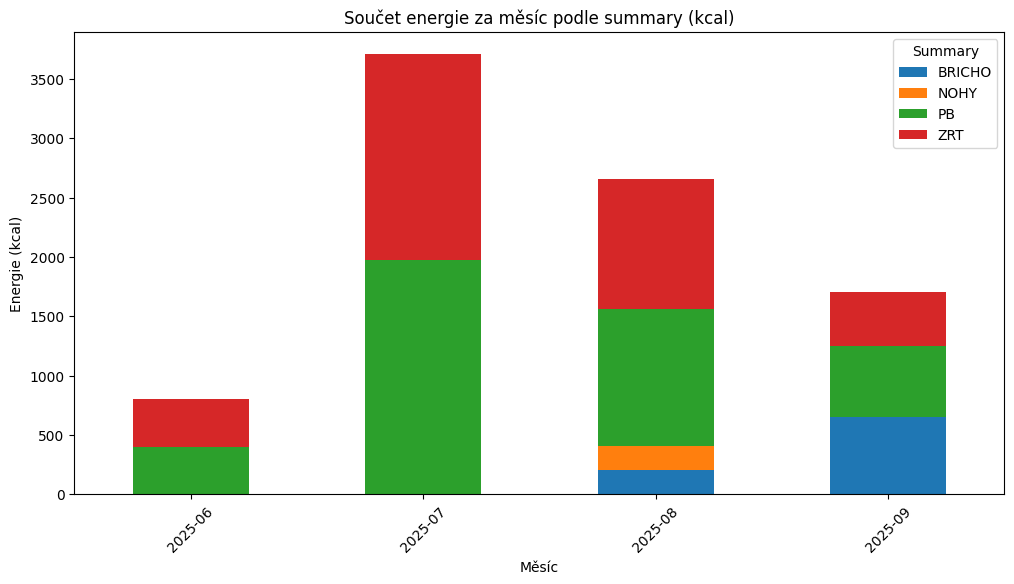

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Měsíc jako perioda
df_exploded["month"] = pd.to_datetime(df_exploded["date"]).dt.to_period("M")

# Součet energie za kombinaci měsíc × summary
energy_sum = df_exploded.groupby(["month", "summary_norm"])["energy_per_category"].sum().unstack(fill_value=0)

# Graf – stacked bar chart
energy_sum.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Součet energie za měsíc podle summary (kcal)")
plt.xlabel("Měsíc")
plt.ylabel("Energie (kcal)")
plt.xticks(rotation=45)
plt.legend(title="Summary")
plt.show()



In [7]:
df

,date,summary,doba,energy,note,month,week,summary_norm,explode_list
0,2025-09-15,"ZRT, břicho",82.0,429,tenisový loket,9,38,"[ZRT, BRICHO]","[{'summary_norm': 'ZRT', 'doba_per_category': ..."
1,2025-09-11,"PB, břicho",72.0,378,tenis. loket,9,37,"[PB, BRICHO]","[{'summary_norm': 'PB', 'doba_per_category': 3..."
2,2025-09-04,"ZRT, břicho",96.0,487,tenisový loket,9,36,"[ZRT, BRICHO]","[{'summary_norm': 'ZRT', 'doba_per_category': ..."
3,2025-09-01,PB,73.0,410,tenis. loket,9,36,[PB],"[{'summary_norm': 'PB', 'doba_per_category': 7..."
4,2025-08-28,ZRT,60.0,304,tenis. loket,8,35,[ZRT],"[{'summary_norm': 'ZRT', 'doba_per_category': ..."
5,2025-08-21,PB,61.0,396,tenis. loket,8,34,[PB],"[{'summary_norm': 'PB', 'doba_per_category': 6..."
6,2025-08-18,ZRT,74.0,399,tenis. loket,8,34,[ZRT],"[{'summary_norm': 'ZRT', 'doba_per_category': ..."
7,2025-08-14,PB,64.0,436,None,8,33,[PB],"[{'summary_norm': 'PB', 'doba_per_category': 6..."
8,2025-08-11,ZRT,60.0,400,None,8,33,[ZRT],"[{'summary_norm': 'ZRT', 'doba_per_category': ..."
9,2025-08-07,"Nohy, břicho",73.0,408,None,8,32,"[NOHY, BRICHO]","[{'summary_norm': 'NOHY', 'doba_per_category':..."


In [8]:
df_exploded

,date,summary,note,month,week,summary_norm,doba_per_category,energy_per_category
0,2025-09-15,"ZRT, břicho",tenisový loket,2025-09,38,ZRT,41.0,214.5
1,2025-09-15,"ZRT, břicho",tenisový loket,2025-09,38,BRICHO,41.0,214.5
2,2025-09-11,"PB, břicho",tenis. loket,2025-09,37,PB,36.0,189.0
3,2025-09-11,"PB, břicho",tenis. loket,2025-09,37,BRICHO,36.0,189.0
4,2025-09-04,"ZRT, břicho",tenisový loket,2025-09,36,ZRT,48.0,243.5
5,2025-09-04,"ZRT, břicho",tenisový loket,2025-09,36,BRICHO,48.0,243.5
6,2025-09-01,PB,tenis. loket,2025-09,36,PB,73.0,410.0
7,2025-08-28,ZRT,tenis. loket,2025-08,35,ZRT,60.0,304.0
8,2025-08-21,PB,tenis. loket,2025-08,34,PB,61.0,396.0
9,2025-08-18,ZRT,tenis. loket,2025-08,34,ZRT,74.0,399.0


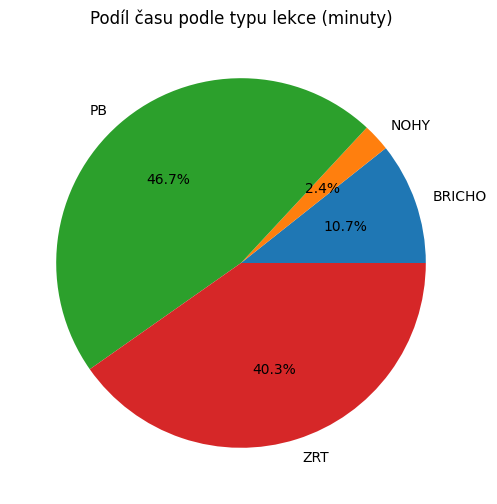

In [9]:
import matplotlib.pyplot as plt

# součet času (doba) podle typu lekce
time_per_lesson = df_exploded.groupby("summary_norm")["doba_per_category"].sum()

# koláčový graf
time_per_lesson.plot(
    kind="pie",
    autopct="%1.1f%%",
    figsize=(6,6)
)
plt.title("Podíl času podle typu lekce (minuty)")
plt.ylabel("")  # odstraní popisek y-osi
plt.show()



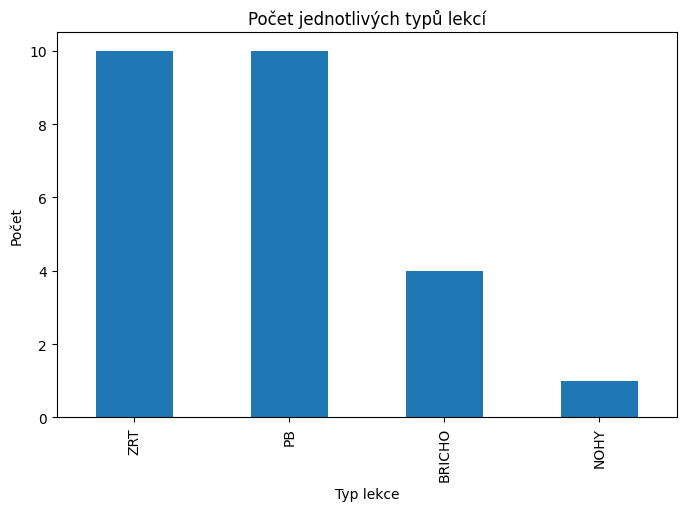

In [10]:
df_exploded["summary_norm"].value_counts().plot(kind="bar", figsize=(8,5))
plt.title("Počet jednotlivých typů lekcí")
plt.xlabel("Typ lekce")
plt.ylabel("Počet")
plt.show()


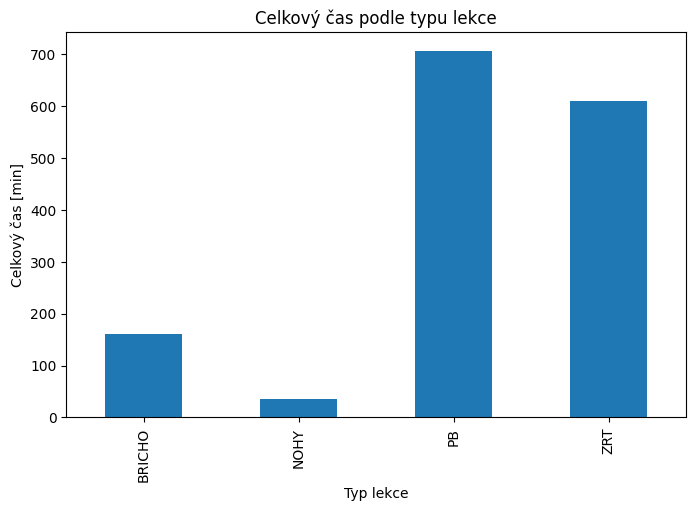

In [11]:
df_exploded.groupby("summary_norm")["doba_per_category"].sum().plot(kind="bar", figsize=(8,5))
plt.title("Celkový čas podle typu lekce")
plt.ylabel("Celkový čas [min]")
plt.xlabel("Typ lekce")
plt.show()


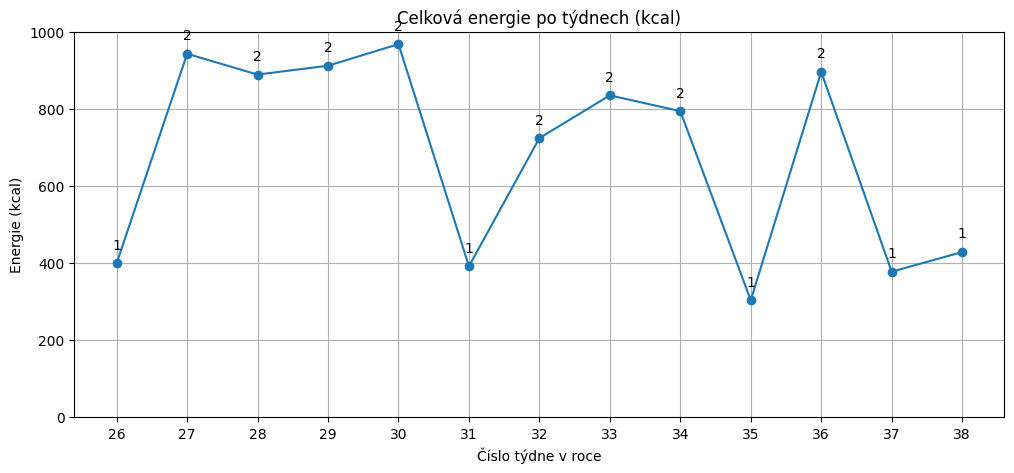

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# jistota: ISO týden jako int
df_exploded["week"] = pd.to_datetime(df["date"]).dt.isocalendar().week.astype(int)

# kompletní rozsah týdnů (v rámci dat v df)
all_weeks = pd.RangeIndex(df["week"].min(), df["week"].max() + 1)

# součet energie po týdnech (0 pro chybějící týdny)
weekly_energy = (
    df.groupby("week", observed=True)["energy"]
      .sum(min_count=1)              # když v týdnu není žádná energie, zůstane NaN
      .reindex(all_weeks, fill_value=0)
      .fillna(0)
)

# počet lekcí po týdnech (pro popisky)
weekly_counts = (
    df.groupby("week", observed=True)
      .size()
      .reindex(all_weeks, fill_value=0)
)

# graf
ax = weekly_energy.plot(kind="line", marker="o", figsize=(12, 5))
ax.set_ylim(0, 1000)
plt.title("Celková energie po týdnech (kcal)")
plt.xlabel("Číslo týdne v roce")
plt.ylabel("Energie (kcal)")
plt.xticks(list(all_weeks))
plt.grid(True)

# popisky: počet lekcí nad body
offset = max(1, weekly_energy.max() * 0.03)  # drobný odsaz
for week, value in weekly_energy.items():
    ax.text(week, value + offset, str(int(weekly_counts.loc[week])), ha="center", va="bottom")

plt.show()



/var/folders/px/7v29qw4j1fq7r7dx3wzzggyr0000gn/T/ipykernel_45814/1710748870.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")   # nebo "viridis", "plasma" atd.


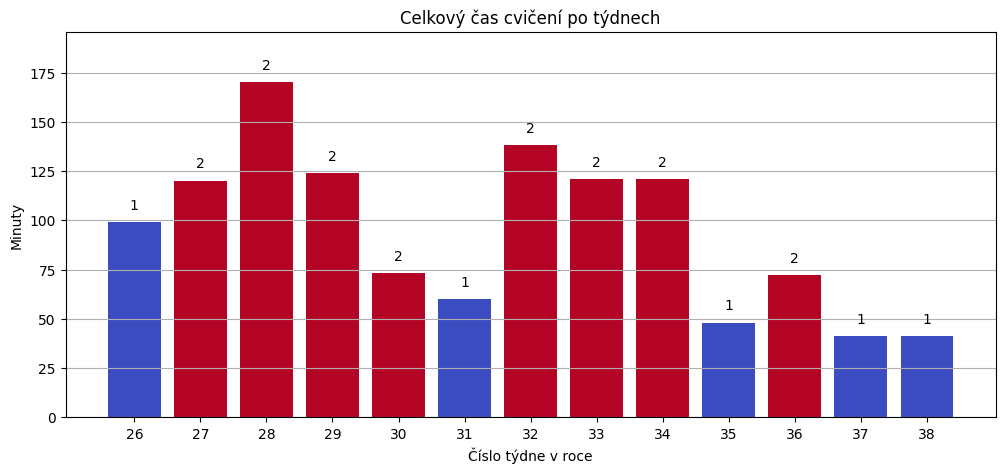

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# --- jistota: vytvoř sloupec week jako int ---
df_exploded["week"] = pd.to_datetime(df["date"]).dt.isocalendar().week.astype(int)

# kompletní rozsah týdnů (int list)
start_week = int(df["week"].min())
end_week = int(df["week"].max())
all_weeks = list(range(start_week, end_week + 1))

# součet minut (doba) po týdnech, přeuspořádaný podle all_weeks
weekly_minutes = (
    df_exploded.groupby("week", observed=True)["doba_per_category"]
      .sum()
      .reindex(all_weeks, fill_value=0)
      .astype(float)
)

# počet lekcí po týdnech (pro barvy / popisky)
weekly_counts = (
    df_exploded.groupby("week", observed=True)
      .size()
      .reindex(all_weeks, fill_value=0)
      .astype(int)
)

# --- barevná škála podle počtu lekcí ---
vmin = weekly_counts.min()
vmax = weekly_counts.max()
# zabrání dělení nulou, když jsou všechny hodnoty stejné
if vmin == vmax:
    norm = plt.Normalize(vmin - 1, vmax + 1)
else:
    norm = plt.Normalize(vmin, vmax)
cmap = cm.get_cmap("coolwarm")   # nebo "viridis", "plasma" atd.
colors = cmap(norm(weekly_counts.values))

# --- vykreslení ---
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(all_weeks))  # pozice na ose x

bars = ax.bar(x, weekly_minutes.values, color=colors)
ax.set_ylim(0, max(130, weekly_minutes.max() * 1.15))  # minimální max 130, nebo dynamické
ax.set_title("Celkový čas cvičení po týdnech")
ax.set_xlabel("Číslo týdne v roce")
ax.set_ylabel("Minuty")
ax.set_xticks(x)
ax.set_xticklabels(all_weeks, rotation=0)
ax.grid(axis="y")

# přidání počtu lekcí nad sloupce
offset = max(1, weekly_minutes.max() * 0.03)
for i, (val, cnt) in enumerate(zip(weekly_minutes.values, weekly_counts.values)):
    ax.text(i, val + offset, str(int(cnt)), ha='center', va='bottom')

plt.show()



Sekvenční (pro hodnoty od nízké po vysokou)

    viridis – tmavě modrá → žlutá, velmi dobře čitelná

    plasma – fialová → žlutá, kontrastní a živá

    inferno – černá → žlutá, hodně kontrastu

    magma – tmavá → světle fialová, jemnější než inferno

    cividis – modro-žlutá, vhodné pro barevně slabozraké

2️⃣ Divergentní (pro hodnoty kolem střední hodnoty)

    coolwarm – modrá ↔ červená

    bwr – modrá ↔ bílá ↔ červená

    seismic – tmavě modrá ↔ bílá ↔ červená

3️⃣ Kategorické / diskrétní

    tab10, tab20, Set1, Set2, Accent – pro oddělení skupin/barvy jednotlivých kategorií